In [1]:
import cv2
import numpy as np
from skimage.morphology import disk, erosion
import matplotlib.pyplot as plt

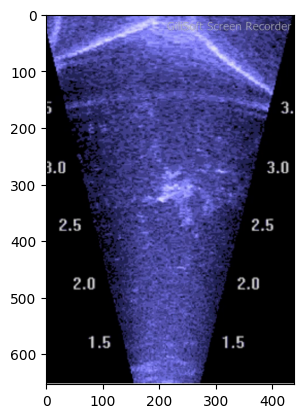

In [2]:
image = cv2.imread( "sample.png")	# reading input image

image = cv2.cvtColor( image, cv2.COLOR_BGR2RGB)	# converting color channels from BGR to RGB

plt.imshow( image)

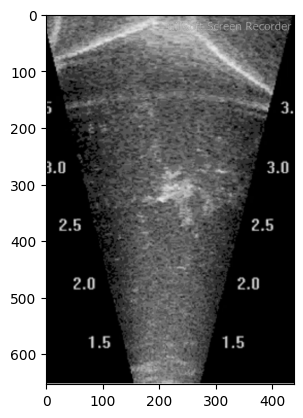

In [3]:
gray_image = cv2.cvtColor( image, cv2.COLOR_BGR2GRAY)	# converting image to Gray

plt.imshow( gray_image, cmap="gray")

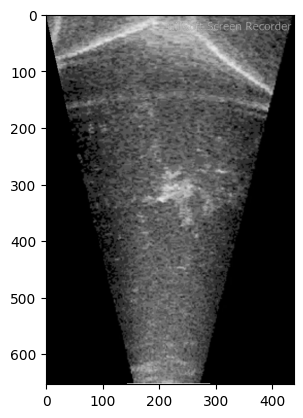

In [4]:
# removing unwanted margins

height, width = gray_image.shape

mask = np.zeros_like( gray_image)

# creating a polygon shape for interested region/area
polygon = np.array( [
	[ width * 0.33, height],	# Bottom-left
	[ width * 0.66, height],	# Botton-Right
	[ width, 0],				# Top-Right
	[ 0, 0],					# Top-Left
], np.int32)

mask = cv2.fillPoly( mask, [ polygon], 255)

masked_image = cv2.bitwise_and( gray_image, mask)

plt.imshow( masked_image, cmap="gray")

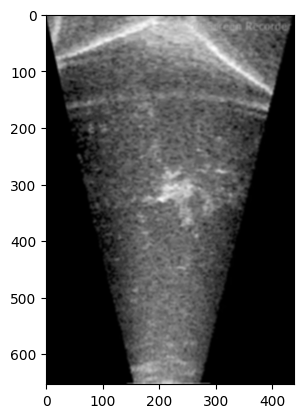

In [5]:
# Bluring Image for denoising
blurred_image = cv2.GaussianBlur( masked_image, ( 5, 5), sigmaX=2, sigmaY=2)

plt.imshow( blurred_image, cmap="gray")

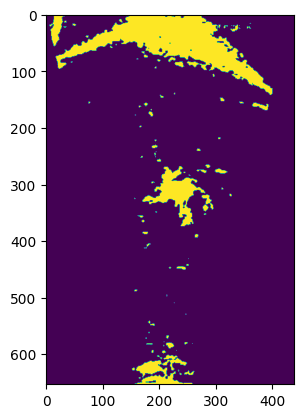

In [6]:
# Thresholding the brightness

c = 0.5

_, binary_image = cv2.threshold( blurred_image, c * 255, 255, cv2.THRESH_BINARY)

plt.imshow( binary_image)

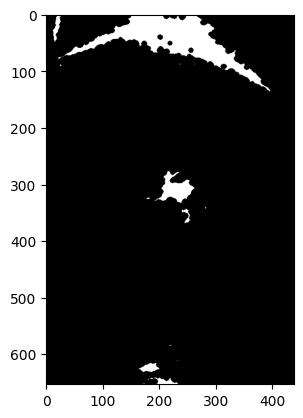

In [7]:
# Eroding the binary image to remove small noise

footprint = disk( 4)

eroded_frame = erosion( binary_image, footprint)

plt.imshow( eroded_frame, cmap="gray")

In [8]:
# selecting bright pixels
bright_pixels = np.column_stack( np.where( binary_image > 0))

In [9]:
# KMeans Clustering Algorithm with Minimum Centeroid Distance Constraint

def Kmeans( X, k, lambda_, min_dist, tol=1e-4, max_iter=100, n_iter=10):
	
	# n: number of samples
	# f: number of features
	n, f = X.shape

	best_inertia = float( "inf")
	best_centeroids = None
	best_lables = None

	for _ in range( n_iter):
		
		np.random.seed()
		centeroids = X[ np.random.choice( n, k, replace=False)].astype( float)

		for _ in range( max_iter):
			new_centeroids = centeroids.copy()

			distances = np.linalg.norm( X[ :, np.newaxis] - centeroids, axis=2)
			
			labels = np.argmin( distances, axis=1)

			for i in range( k):
				co_dist = np.array( [ np.linalg.norm( centeroids[ i] - centeroids[ j]) for j in range( k)])

				if len( X[ labels == i]) > 0:
					gradient_1 = np.mean( X[ labels == i], axis=0) - centeroids[ i]
				else:
					gradient_1 = np.zeros_like( centeroids[ i])
					
				gradient_2 = lambda_ * ( ( centeroids[ i] - centeroids[ co_dist < min_dist]) * 0.5).sum( axis=0)
				
				new_centeroids[ i] += gradient_1 + gradient_2

			if np.linalg.norm( new_centeroids - centeroids) < tol:
				break

			centeroids = new_centeroids

		distances = np.linalg.norm( X[ :, np.newaxis] - centeroids, axis=2)
		inertia = np.sum( np.min( distances, axis=1) ** 2)

		if inertia < best_inertia:
			best_inertia = inertia
			best_centeroids = centeroids
			best_lables = labels

	return best_centeroids, best_lables


In [10]:
# Perform K-Means clustering on the bright pixels
clusters, lables = Kmeans( X=bright_pixels,
						   lambda_=0.5,
						   k=7,
						   min_dist=30,
						   tol=1e-4,
						   max_iter=100,
						   n_iter=10)

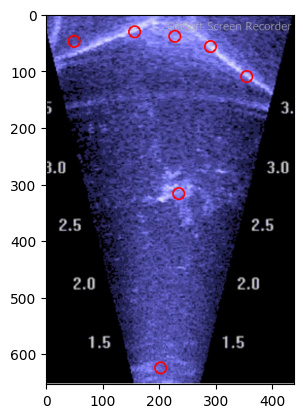

In [11]:
cluster_centers = clusters.astype( int)
output_image = image.copy()

for c in cluster_centers:
	cv2.circle( output_image, ( c[ 1], c[ 0]), 10, ( 255, 0, 0), 2)

plt.imshow( output_image)

In [12]:
np.array( cluster_centers)

array([[317, 234],
       [625, 202],
       [ 48,  49],
       [110, 354],
       [ 31, 156],
       [ 39, 227],
       [ 57, 290]])